Interpolacja wielomianowa


Kolejne kroki będą prowadzić do wyznaczenia współczynników wielomianu interpolującego funkcję $f$ w wybranych węzłach. Współczynników wielominanu Lagrange'a i wielomianu w postaci Newtona.

Funkcja $\text{compute coeff sigma from nodes}$ uruchomiona dla wybranych wezłów $\text{nodes}$ i funkcji $f$ zwraca współczynniki $\sigma_{i}$ wielomianu interpolacyjnego Lagrange'a.

In [29]:
using Plotly
using Printf

In [30]:
function compute_coeff_sigma( X::Vector{Float64}, A::Vector{Float64} )
    n = length(X) - 1
    a = Array{Float64,2}(undef, n+5, n+5)

    for i in 1:n+1  
        value = getindex(A,i)
        setindex!(a, value, i, 1)
    end

    for i in 2:n+1  
        for k in 1:i-1
        value = getindex(a,k,i-1)/(getindex(X,k)-getindex(X,i))
        setindex!(a,value,k,i)

        value = getindex(a,i,k) - getindex(a,k,i)
        setindex!(a,value,i,k+1)
        end
    end

    sigma = Array{Float64,1}(undef,n+1)
    for i in 1:n+1
        setindex!(sigma,getindex(a,i,n+1),i)
    end
    return sigma
end

function compute_coeff_wi( X::Vector{Float64} )
    n = length(X) - 1
    a = Array{Float64,1}(undef, n+1)

    for i in 1:n+1 
        setindex!(a,0,i)
    end
    setindex!(a,1,1)

    return compute_coeff_sigma(X,a)
end

function compute_coeff_sigma_from_nodes( X::Vector{Float64}, f )
    n = length(X) - 1
    w_i = compute_coeff_wi(X)
    sigma = Array{Float64,1}(undef,n+1)

    for i in 1:n+1 
        value = getindex(w_i,i) * f(getindex(X,i))
        setindex!(sigma,value,i)
    end
    return sigma
end

compute_coeff_sigma_from_nodes (generic function with 1 method)

Funkcja $\text{compute coeff ai}$ realizuje algorytm konwertujący dane współczynniki Lagranga'a $\sigma{i}$ na współczynniki Newtona $a_{i}$

In [31]:
function compute_coeff_ai( X::Vector{Float64}, Sigma::Vector{Float64} )
    n = length(X) - 1
    s = Array{Float64,2}(undef, n+2, n+2)

    for i in 1:n+1
        setindex!(s,getindex(Sigma,i),i,1)
    end

    a = Array{Float64,1}(undef,n+1)
    for k in 1:n+1
        sum = 0
        for i in 1:((n+2)-k)          
            sum+=getindex(s,i,k)
        end

        setindex!(s,sum,n+2-k,k+1)  
        setindex!(a,sum,n+2 - k)

        for i in (n+2-k):-1:1
            value = (getindex(X,i) - getindex(X,n+2-k)) * getindex(s,i,k)

            setindex!(s,value,i,k+1)
        end
    end

    return a
end

compute_coeff_ai (generic function with 1 method)

Funkcja $\text{compute lagrangian pol value}$ oblicza wartość wielomianu interpolacyjnego Lagrange'a w zadanym punkcie $x$ i o określonych współczynnikach $\sigma_{i}$. Funkcja $\text{compute newton pol value}$ oblicza wartość wielomianu interpolacyjnego Newtona w zadanym punkcie $x$ i  o określonych współczynnikach $a_{i}$.

In [32]:
function compute_lagrangian_pol_value( coeff_wi, X, f, x )

    n = length(X) -1
    l = 0.0 
    m = 0.0

    for i in 1:n+1
        if getindex(X,i) == x
            return f(x)
        end
    end

    for i in 1:n+1
        x_i = getindex(X,i)
        t = x - x_i
        w = getindex(coeff_wi,i) / t

        l = l + w*f(x_i)
        m = m + w
    end 
    
    result = l/m
    return result
end

function compute_newton_pol_value( coeff_ai, X, x )
    n = length(X) - 1
    
    val = getindex(coeff_ai,n+1)   
    for i in n:-1:1
        val = val * (x - getindex(X,i)) + getindex(coeff_ai,i)
    end

    return val
end

compute_newton_pol_value (generic function with 1 method)

In [33]:
function get_nodes( a, b, amount )
    nodes = Array{Float64,1}(undef,amount+1)

    h = (b-a)/amount
    for i in 0:amount
        setindex!(nodes,a +i*h, i+1)
    end
    return nodes
end

get_nodes (generic function with 1 method)

In [34]:
f1(x) = (1 + 25*x^2)^-1

f1 (generic function with 1 method)

In [35]:
amount_of_nodes = 10
a = -1 
b = 1

nodes = get_nodes(a,b,amount_of_nodes)
sigma_coeffs = compute_coeff_sigma_from_nodes(nodes,f1)
ai_coeffs = compute_coeff_ai(nodes,sigma_coeffs)

wi_coeff = compute_coeff_wi(nodes)

L(x) = compute_lagrangian_pol_value(wi_coeff,nodes,f1,x)
N(x) = compute_newton_pol_value(ai_coeffs,nodes,x)

N (generic function with 1 method)

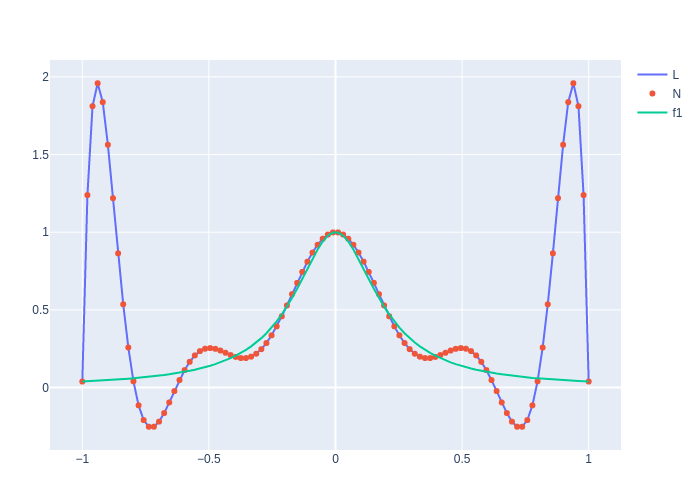

In [36]:
plot_x = range(a, stop=b, length=100)
plot_f1 = map(f1, plot_x)

plot_L = map(L, plot_x)
plot_N = map(N, plot_x)

trace_L = Plotly.scatter(x=plot_x, y=plot_L,
                    mode="lines",
                    name="L")
trace_f1 = Plotly.scatter(x=plot_x, y=plot_f1,
                    mode="lines",
                    name="f1")
trace_N = Plotly.scatter(x=plot_x, y=plot_N,
                    mode="markers",
                    name="N")
                    
plot([trace_L, trace_N, trace_f1])

Dokładność wielomianu interpolacyjnego Lagrange'a L(x) i dokładność wielomianu interpolacyjnego Newtona N(x) można odczytać z poniższych danych.

In [37]:
delta_L = map(abs, plot_L - plot_f1)
@printf("suma bledow L = %.16f, max bledow = %.16f\n", sum(delta_L), maximum(delta_L))

delta_N = map(abs, plot_N - plot_f1)
@printf("suma bledow N = %.16f, max bledow = %.16f\n", sum(delta_N), maximum(delta_N))

suma bledow L = 28.6413629869507815, max bledow = 1.9154342696798867
suma bledow N = 28.6413629869549560, max bledow = 1.9154342696801769


In [38]:
f2(x) = atan(x)

f2 (generic function with 1 method)

In [39]:
amount_of_nodes = 15
a = -1 
b = 1

nodes = get_nodes(a,b,amount_of_nodes)
sigma_coeffs = compute_coeff_sigma_from_nodes(nodes,f2)
ai_coeffs = compute_coeff_ai(nodes,sigma_coeffs)

wi_coeff = compute_coeff_wi(nodes)

L(x) = compute_lagrangian_pol_value(wi_coeff,nodes,f2,x)
N(x) = compute_newton_pol_value(ai_coeffs,nodes,x)

N (generic function with 1 method)

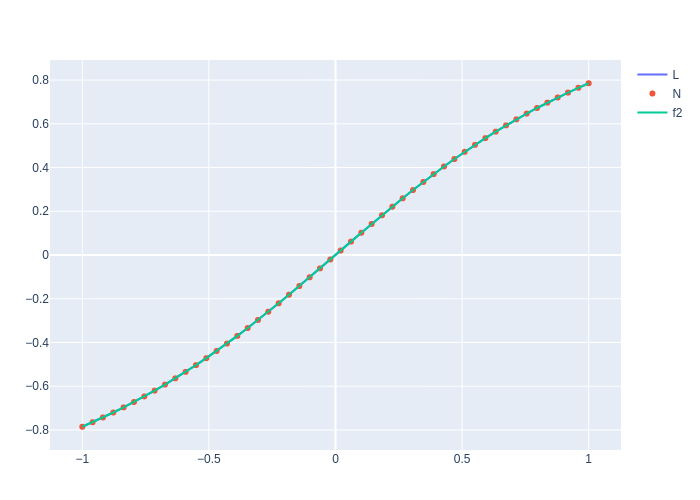

In [40]:
plot_x = range(a, stop=b, length=50)
plot_f2 = map(f2, plot_x)

plot_L = map(L, plot_x)
plot_N = map(N, plot_x)

trace_L = Plotly.scatter(x=plot_x, y=plot_L,
                    mode="lines",
                    name="L")
trace_f2 = Plotly.scatter(x=plot_x, y=plot_f2,
                    mode="lines",
                    name="f2")
trace_N = Plotly.scatter(x=plot_x, y=plot_N,
                    mode="markers",
                    name="N")
                    
plot([trace_L, trace_N, trace_f2])

Dokładność wielomianu interpolacyjnego Lagrange'a L(x) i dokładność wielomianu interpolacyjnego Newtona N(x) można odczytać z poniższych danych.

In [41]:
delta_L = map(abs, plot_L - plot_f2)
@printf("suma bledow L = %.16f, max bledow = %.16f\n", sum(delta_L), maximum(delta_L))

delta_N = map(abs, plot_N - plot_f2)
@printf("suma bledow N = %.16f, max bledow = %.16f\n", sum(delta_N), maximum(delta_N))

suma bledow L = 0.0000176826415754, max bledow = 0.0000050166549024
suma bledow N = 0.0000176826322779, max bledow = 0.0000050166548861
